# 

# Runoff Setup

by Feng Zhu (fengzhu@ucar.edu)

---------

**NOTES**

- This notebook is adapted from [PaleoToolkit_Recipe_2020Jan1](https://github.com/CESM-Development/paleoToolkit/blob/master/cesm1_2/PaleoToolkit_Recipe_2020Jan1.pdf) by Mathew Rothstein, Nan Rosenbloom, and Christine Shields.
- This notebook is tested with the Python environment "npl-2023a" on Cheyenne & Casper.
- Required input data:
    - topography-bathymetry file: [miocene_topo_pollard_antscape_dolan_0.5x0.5.nc](/glade/u/home/fengzhu/CESM/PaleoToolkit/rtm/data/miocene_topo_pollard_antscape_dolan_0.5x0.5.nc)
    - OCN SCRIP file: [gx1vMIO_130423.nc]('/glade/work/jiangzhu/data/inputdata/miocene/gx1vMIO_130423.nc')


In [1]:
import xarray as xr
import os
os.chdir('/glade/u/home/fengzhu/CESM/PaleoToolkit/rtm/notebooks/')

casename = 'Miocene'
topo_path = '../data/miocene_topo_pollard_antscape_dolan_0.5x0.5.nc'
scrp_path = '/glade/work/jiangzhu/data/inputdata/miocene/gx1vMIO_130423.nc' #'/glade/p/cesmdata/inputdata/share/scripgrids/1x1d_010201.nc'

In [2]:
# useful functions

def replace_str(fpath, d):
    ''' Replace the string in a given text file according
    to the dictionary `d`
    '''
    with open(fpath, 'r') as f:
        text = f.read()
        for k, v in d.items():
            search_text = k
            replace_text = v
            text = text.replace(search_text, replace_text)

    with open(fpath, 'w') as f:
        f.write(text)

## Step 19: prep topo file at proper resolution

To help the process of making changes in the runoff setup, it is highly recommended to run RTM (the active runoff model required for deep-time model runs in CESM) at a resolution no finer than 1deg. If the topography-bathymetry file used in earlier steps needs to be interpolated to another resolution, the following tool may help.

- input: topography-bathymetry file (same as used in step 1)
- output: topo.1x1deg.$CASE.nc (used in step 20)

### 19a.

In [3]:
fpath = './create-topo_1x1deg.ncl'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/create-topo_1x1deg.ncl

A    create-topo_1x1deg.ncl
Export complete.


Note: code for other resolutions are available from same directory

- set CASE as in earlier steps
- set fili to topo-bath file to interpolate from
- code assumes variables in topo file are named 'lat','lon', and 'topo' modify variable names in ncl code accordingly

In [4]:
# check the variable names
ds = xr.open_dataset(topo_path)
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
Data variables:
    topo     (lat, lon) float32 ...
Attributes:
    desc:     Updated from Herold et al. (2008) using a blended ANTSCAPE/Dave...
    title:    Miocene 0.5x0.5 degree topography

In [5]:
# modify the NCL file
replace_str(
    fpath,
    {
        '<casename>': casename,
        '<input_topo-bath_filename>': topo_path,
    },
)

### 19b.

In [6]:
# execute the NCL file
!ncl $fpath

 Copyright (C) 1995-2019 - All Rights Reserved
 University Corporation for Atmospheric Research
 NCAR Command Language Version 6.6.2
 The use of this software is governed by a License Agreement.
 See http://www.ncl.ucar.edu/ for more details.


## Step 20: generate runoff data from topo inputs

- input: topography/bathymetry file (from step 19 or same file as was used in step 1)
- output:
    - fort.10_$CASE (CLM-required format, before inf loops fixed, used in step 21)
    - fort.11_$CASE (list of points involved in inf loops, used in step 21)
    - fort.12_$CASE
    - fort.13_$CASE (CLM-required format, after inf loops fixed, used in step 21)
    - fort.14_$CASE
    - fort.15_$CASE

### 20a.

In [7]:
fpath = './rdirc_template.csh'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/rdirc_template.csh

A    rdirc_template.csh
Export complete.


Rename the template file to something appropriate for your work, for example, rdirc_PETM.csh

- set CASE as in earlier steps
- set INFILE to path and name of input topo/bath file (from step 19 or same file as was used in step 1)

In [8]:
fpath_new = f'./rdirc_{casename}.csh'
os.rename(fpath, fpath_new)

replace_str(
    fpath_new,
    {
        '<casename>': casename,
        '<path/topography-bathymetry_file>': topo_path,
    },
)

### 20b.

In [9]:
fpath = './topo2rdirc_sed.F90'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/topo2rdirc_sed.F90

A    topo2rdirc_sed.F90
Export complete.


- code assumes variables in topo file are named 'lat','lon', and 'topo' modify variable names in fortran code accordingly
- modify nlon, nlat depending on desired resolution of output for RTM to run (which must match the resolution of the topo input) (for 1deg, nlon=360 and nlat=180)

### 20c.

In [10]:
!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/Makefile

A    Makefile
Export complete.


### 20d.

In [30]:
replace_str(
    fpath,
    {
        'pause': 'WRITE(*, *)',  # to avoid the prompts
    },
)

In [31]:
!chmod +x "rdirc_$casename".csh
!./"rdirc_$casename".csh

set verbose





































set INFILE = ../data/miocene_topo_pollard_antscape_dolan_0.5x0.5.nc
set INFILE = ../data/miocene_topo_pollard_antscape_dolan_0.5x0.5.nc
set CASE = Miocene
set CASE = Miocene





cat > ! pathname.sed << EOF
cat
cp topo2rdirc_sed.F90 topo2rdirc.F90
cp topo2rdirc_sed.F90 topo2rdirc.F90
sed -f pathname.sed topo2rdirc_sed.F90 > ! topo2rdirc.F90
sed -f pathname.sed topo2rdirc_sed.F90




cp $INFILE .
cp ../data/miocene_topo_pollard_antscape_dolan_0.5x0.5.nc .
make topo2rdirc
make topo2rdirc
ifort -assume byterecl -o topo2rdirc topo2rdirc.F90 -I/glade/apps/opt/netcdf/4.2/intel/default/include -L/glade/apps/opt/netcdf/4.2/intel/default/lib -lnetcdf
echo '' > fort.10
echo 
echo '' > fort.11
echo 
echo '' > fort.12
echo 
echo '' > fort.13
echo 
echo '' > fort.14
echo 
echo '' > fort.15
echo 
./topo2rdirc
./topo2rdirc
 Successfully opened ../data/miocene_topo_pollard_antscape_dolan_0.5x0.5.nc
 successfully read netcdf topography file
 netcdf topog

Note: Job may pause (reporting an error) when an issue is found (like an infinite loop). Just hit enter at the prompt and the program will attempt to correct the issue and the output files will document what was done.

FZ: with the modified file, there will be no prompts any more!

## Step 21: plot runoff (optional)

- input:
    - topo-bath filename from step 19 (used in plot and output filename only)
    - fort.10_$CASE (from step 20)
    - fort.11_$CASE (from step 20)
    - fort.13_$CASE (from step 20)

- output: rdirc_<topo-bath_filename>.ps

### 21a.

In [40]:
fpath = './plotrdirc.csh'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/plotrdirc.csh

A    plotrdirc.csh
Export complete.


- set IFILE (same topo-bath file used in step 20)
- set CASE (same casename as used in step 20)
- modify NLAT,NLON,RESOLN depending on resolution of input topo file

In [41]:
replace_str(
    fpath,
    {
        '<casename>': casename,
        '<topography-bathymetry_file>': os.path.basename(topo_path),
    },
)

### 21b.

In [42]:
fpath = './plot_rdirc.ncl'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/plot_rdirc.ncl

A    plot_rdirc.ncl
Export complete.


- modify res@mpMinLatF, res@mpMaxLatF, res@mpMinLonF, res@mpMaxLonF in the section labeled "Zoom in on data" to zoom in on geographical area of interest (leaving these commented out will give global a plot)

### 21c.

In [43]:
!chmod +x ./plotrdirc.csh
!./plotrdirc.csh

set verbose








set IFILE = miocene_topo_pollard_antscape_dolan_0.5x0.5.nc
set IFILE = miocene_topo_pollard_antscape_dolan_0.5x0.5.nc
setenv NLAT 180
setenv NLAT 180
setenv NLON 360
setenv NLON 360
set RESOLN = 1x1
set RESOLN = 1x1











setenv CASE Miocene
setenv CASE Miocene
setenv PLOTNAME rdirc_${IFILE}
setenv PLOTNAME rdirc_miocene_topo_pollard_antscape_dolan_0.5x0.5.nc






setenv RFILE1 fort.10_$CASE
setenv RFILE1 fort.10_Miocene
setenv EFILE1 fort.11_$CASE
setenv EFILE1 fort.11_Miocene

setenv RFILE2 fort.13_$CASE
setenv RFILE2 fort.13_Miocene
setenv EFILE2 fort.14_$CASE
setenv EFILE2 fort.14_Miocene





if ( -e rdirc.$RESOLN.$CASE ) then
if ( -e rdirc.1x1.Miocene ) then
echo 'removing old file: ' rdirc.$RESOLN.$CASE
echo removing old file:  rdirc.1x1.Miocene
removing old file:  rdirc.1x1.Miocene
rm rdirc.$RESOLN.$CASE
rm rdirc.1x1.Miocene
endif
endif

cp fort.13_$CASE rdirc.$RESOLN.$CASE
cp fort.13_Miocene rdirc.1x1.Miocene

ncl < plot_rdirc.ncl
ncl
 Copyright (C) 1

### 21d.

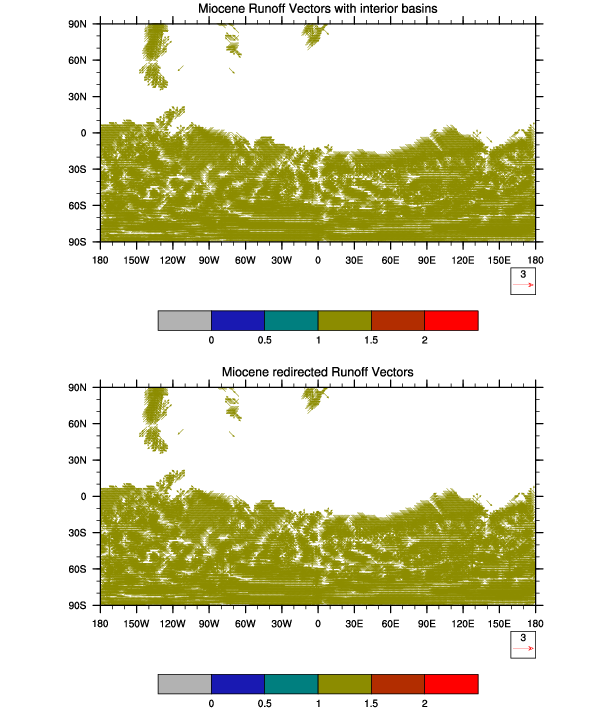

In [52]:
fname = os.path.basename(topo_path)
!convert "rdirc_$fname".ps "rdirc_$fname".png

from IPython.display import display, Image
display(Image(filename=f'./rdirc_{fname}.png'))

Note: top plot is the uncorrected runoff map, bottom plot is the corrected; arrows are plotted showing direction of runoff at each grid cell

## Step 22: modify runoff

- input: fort.13_$CASE (from step 20)
- output: fort.13_$CASE

### 22a.

edit fort.13_$CASE (use your favorite editor)

Note: fort.13_$CASE *should* have all infinite loops corrected, but if a change is needed to the runoff in a region (perhaps there are salinity issues in the model run) then runoff values in this file would need to be modified. This is a text file with three columns of data for lat,lon and direction, where values range from 0-8 (0=ocean, 1=north and rotating clockwise to 8=northwest).

## Step 23: check for infinite loops (optional)

note: If fort.13_$CASE was modified in step 22, another check for any infinite loops introduced might be warranted; then iterate with steps 21 and 22 until satisfied

- input: fort.13_$CASE (from step 20 or 22)
- output: fort.11 (only produced if any infinite loops found)

### 23a.

In [56]:
fpath = './check_inf_loop.F90'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/check_inf_loop.F90

A    check_inf_loop.F90
Export complete.


- modify nlat,nlon for resolution of input
- set filei to 'fort.13_$CASE'

In [60]:
replace_str(
    fpath,
    {
        'fort.10': f'fort.13_{casename}',
        'pause': 'WRITE(*, *)',  # to avoid the prompts
    },
)

### 23b.

In [61]:
!make check_inf_loop

ifort -assume byterecl -o check_inf_loop check_inf_loop.F90 -I/glade/apps/opt/netcdf/4.2/intel/default/include -L/glade/apps/opt/netcdf/4.2/intel/default/lib -lnetcdf


### 23c.

In [62]:
!./check_inf_loop

 lat =   -89.7500000000000       -89.7500000000000       -89.2500000000000     
  -89.2500000000000       -88.7500000000000       -88.7500000000000     
  -88.2500000000000       -88.2500000000000       -87.7500000000000     
  -87.7500000000000       -87.2500000000000       -87.2500000000000     
  -86.7500000000000       -86.7500000000000       -86.2500000000000     
  -86.2500000000000       -85.7500000000000       -85.7500000000000     
  -85.2500000000000       -85.2500000000000       -84.7500000000000     
  -84.7500000000000       -84.2500000000000       -84.2500000000000     
  -83.7500000000000       -83.7500000000000       -83.2500000000000     
  -83.2500000000000       -82.7500000000000       -82.7500000000000     
  -82.2500000000000       -82.2500000000000       -81.7500000000000     
  -81.7500000000000       -81.2500000000000       -81.2500000000000     
  -80.7500000000000       -80.7500000000000       -80.2500000000000     
  -80.2500000000000       -79.7500000000000 

Note: job may pause as issues are encountered and recorded - just hit enter at the prompt to continue. If the job does not pause, it likely encounted no infinite loops. Otherwise, just hit enter at the prompt to continue and any issues should be recorded in fort.11.

FZ: with the modified file, there will be no prompts any more!

## Step 24: convert runoff file to netcdf

- input: fort.13_$CASE (from step 20 or 22)
- output: rdirc.1x1.$CASE.nc (used in user_nl_rtm)

### 24a.

In [95]:
fpath = './rtm_ncdf.pro'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/rtm_ncdf.pro

A    rtm_ncdf.pro
Export complete.


- set rtmfile1 = 'fort.13_$CASE'
- set outfile = 'rdirc.1x1.$CASE.nc' ;approprate resolution in name
- set resnum=2 (1deg) or resnum=1 (0.5deg)
- set history attribute with proper documentation for user and date
- set source attribute with proper input file (fort.13_$CASE)

In [96]:
replace_str(
    fpath,
    {
        '<casename>': casename,
        '<user>': 'Feng Zhu',
        '<date>': '20230514',
        "if !d.name eq 'X' then device, decomp=0": ";if !d.name eq 'X' then device, decomp=0",  # so that Xwindows is not required
    },
)

### 24b.

make sure you login with Xwindows enabled - for example:

```sh
'ssh -Y -l <user> cheyenne.ucar.edu'
module load idl
idl
IDL> .rn rtm_ncdf
IDL> rtm
IDL> exit
```

FZ: with the modified file, there's no need to login with Xwindows enabled.

In [97]:
# run IDL
!source /glade/u/apps/ch/opt/lmod/8.7.13/lmod/lmod/init/zsh && module load idl && printf '.rn rtm_ncdf\nrtm\nexit\n' | idl

IDL 8.7.2 (linux x86_64 m64).
(c) 2019, Harris Geospatial Solutions, Inc.

Licensed for use by: NCAR UCAR - 95183
License: 95183
A new version is available: IDL 8.9
https://www.l3harrisgeospatial.com/Product-Downloads/
 
% Compiled module: RTM.
% Loaded DLM: NCDF.


## Step 25: create runoff to ocean mapping file

- input: fort.13_$CASE (from step 20 or 22) $ocnres_$date.nc (SCRIP mapping file from step 2)
- output:
    - map_$rofres$CASE_to_$ocnres_nn_<date>.nc map_$rofres$CASE_to_$ocnres_sm_e1000r300_<date>.nc
    - map_$rofres$CASE_to_$ocnres_nnsm_e1000r300_<date>.nc (ROF2OCN_RMAPNAME in env_run.xml)

### 25a.

In [3]:
fpath = './runoff_map_1deg'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/runoff_map_1deg

A    runoff_map_1deg
Export complete.


Note: runoff_map_0.5deg executable is also available

Note: if using a machine other than cheyenne or executables require rebuild, get source code and makefile template to build new executables:

```sh
svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/runoff_map_src
cd runoff_map_src
cp src/map_mod_1deg.F90_save src/map_mod.F90 (or map_mod_0.5deg.F90_save)
./build.cheyenne
cp runoff_map ../runoff_map_1deg (or runoff_map_0.5deg)
cd ..
```

### 25b.

In [4]:
fpath = './runoff_map.1x1.template.nml'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/runoff_map.1x1.template.nml

A    runoff_map.1x1.template.nml
Export complete.


Rename the template file to something appropriate for your work, for example, runoff_map.1x1.PETM.nml

- set file_roff to fort.13_$CASE
- set file_ocn to the SCRIP_mapping file
- replace <casename> with $CASE in each of the output files and title
- replace <ocnres> with $ocnres in each of the output files and title (ie gx1PETM)
- replace <date> with current date in each of the output files

In [5]:
fpath_new = f'./runoff_map.1x1.{casename}.nml'
os.rename(fpath, fpath_new)

replace_str(
    fpath_new,
    {
        '<casename>': casename,
        './<SCRIP_mapping_file>': scrp_path,
        '<ocnres>': 'gx1Miocene',
        '<date>': '20230514',
    },
)

### 25c.

- create softlink to namelist file

In [6]:
!ln -s "runoff_map.1x1.$casename".nml ./runoff_map.nml

ln: failed to create symbolic link ‘./runoff_map.nml’: File exists


### 25d.

In [7]:
!chmod +x ./runoff_map_1deg
!./runoff_map_1deg

(main) -------------------------------------------------------------------------
(main) correct/smooth/sort runoff -> ocean map
(main) -------------------------------------------------------------------------
(main) -------------------------------------------------------------------------
(main) SVN  $URL: https://svn-ccsm-models.cgd.ucar.edu/tools/mapping/release_tags/mapping_140603/gen_mapping_files/runoff_to_ocn/src/main.F90 $
(main) -------------------------------------------------------------------------
(main) -------------------------------------------------------------------------
(main) Step 0:  read input namelist data
(main) -------------------------------------------------------------------------
(main) Namelist values...
(main)    gridtype       = rtm
(main)    file_roff      = ./fort.13_Miocene
(main)    file_ocn       = /glade/work/jiangzhu/data/inputdata/miocene/gx1vMIO_130423.nc
(main)    file_nn        = map_r1x1Miocene_to_gx1Miocene_nn_20230514.nc
(main)    file_smoo

## Step 26: create runoff to ocean mapping file (part 2)

- input:
    - $ocnres_$date.nc (SCRIP mapping file from step 2)
    - /glade/p/cesmdata/cseg/mapping/grids/1x1d.nc

Note: grids at 0.5deg (r05_nomask_070925.nc) and 2deg (r19.nc) are also available from same grids directory, depending on runoff resolution

- output: map_r1_nomask_TO_$ocnres_aave.\<date\>.nc (ROF2OCN_FMAPNAME in env_run.xml)

### 26a.

In [118]:
fpath = './create_ESMF_map.sh'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/create_ESMF_map.sh

A    create_ESMF_map.sh
Export complete.


### 26b.

In [123]:
oncres = 'gx1Miocene'
date = '20230514'
!chmod +x './create_ESMF_map.sh'
!./create_ESMF_map.sh -fsrc /glade/p/cesm/cseg/mapping/grids/1x1d.nc -nsrc r1_nomask -fdst ./"$ocnres_$date".nc -ndst $ocnres -map aave

./create_ESMF_map.sh
Sun May 14 21:44:28 MDT 2023
****************************
ERROR:: invalid argument aave
****************************

**********************************************************
usage:
./create_ESMF_map.sh  
 A wrapper for the ESMF mapping tool that creates a mapping file
 from the source grid to the destination grid. Specify what type
 of mapping to use with the -maptype flag (aave, blin, bilin,patc,
 nearestdtos, or neareststod)

create_ESMF_map.sh 
  --filesrc|-fsrc  input source grid_filename (required) 
  --filedst|-fdst  input destination grid_filename (required)
  --namesrc|-nsrc  output source name in mapping file (required)
  --namedst|-ndst  output destination name in mapping file (required)
  --maptype|-map   type of mapping [aave|blin|bilin|patc|nearestdtos|neareststod] (required)
  [ --typesrc|tsrc ] [regional|global]
  [ --typedst|tdst ] [regional|global]
  [ --pass2esmf ]    ["options"]
  [ --batch|-b ]
  [ --clm_name ]
  [ --serial ]
  [ -mach|--mach

## Step 27: create runoff to/from land mapping files - needed if rof at 1deg rather than 0.5 deg

Note: If running rtm (runoff model) at a resolotion other than 0.5 deg (it's default), you'll need to specify mapping files between land and runoff that are specific to your resolution. Many such maps can be found here:

/glade/p/cesmdata/cseg/inputdata/lnd/clm2/mappingdata/maps

If no mapping files exist for your resolutions (lnd and rof), use the following steps to create them.

- input:
    - /glade/p/cesmdata/cseg/mapping/grids/1x1d_lonshift.nc
    - /glade/p/cesmdata/cseg/mapping/grids/fv$atmres_\<date\>.nc

Note: grids at other resolutions are available from same grids directory, depending on resolution of atm/land

- output:
    - map_r19_nomask_TO_r1x1_aave.\<date\>.nc (LND2ROF_FMAPNAME in env_run.xml)
    - map_r1x1_TO_r19_aave.\<date\>.nc (ROF2LND_FMAPNAME & ROF2LND_SMAPNAME in env_run.xml)

### 27a.

In [ ]:
fpath = './create_ESMF_map.sh'
if os.path.exists(fpath): os.remove(fpath)

!svn export https://github.com/CESM-Development/paleoToolkit/trunk/cesm1_2/rof/create_ESMF_map.sh

- same script as was used in step 26
- no changes should be required

### 27b.

In [ ]:
atmres = 'fx1Miocene'
!./create_ESMF_map.sh -fsrc /glade/p/cesm/cseg/mapping/grids/fv"$atmres_$date".nc -nsrc r19_nomask -fdst /glade/p/cesm/cseg/mapping/grids/1x1d_lonshift.nc -ndst r1x1 -map aave

### 27c.

In [ ]:
!./create_ESMF_map.sh -fsrc /glade/p/cesm/cseg/mapping/grids/1x1d_lonshift.nc -nsrc r1x1 fdst /glade/p/cesm/cseg/mapping/grids/fv"$atmres_$date".nc -ndst r19 -map aave